In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np
import os
from keras.models import model_from_json
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
train_path="/content/gdrive/My Drive/Soil Data Set New/train"
test_path="/content/gdrive/My Drive/Soil Data Set New/test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/gdrive/MyDrive/Soil Data Set New/train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/content/gdrive/MyDrive/Soil Data Set New/test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')

Found 2264 images belonging to 4 classes.
Found 350 images belonging to 4 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 4,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)


In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
base_model.load_weights("/content/gdrive/My Drive/Soil Data Set New/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff132d9f290> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7ff1b71e0d90> False
<keras.layers.convolutional.Conv2D object at 0x7ff13559d5d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff1335b5a50> False
<keras.layers.core.activation.Activation object at 0x7ff133513510> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff1334d4ad0> False
<keras.layers.convolutional.Conv2D object at 0x7ff133475590> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff133475410> False
<keras.layers.core.activation.Activation object at 0x7ff1334d4710> False
<keras.layers.convolutional.Conv2D object at 0x7ff13347c9d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff13347f0d0> False
<keras.layers.core.activation.Activation object at 0x7ff13347cad0> False
<keras.layers.convolutional.Conv2D object at 0x7ff13348a510> False
<keras

In [ ]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [ ]:
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='')
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
H = model.fit_generator(train_generator,validation_data=test_generator,epochs=10,verbose=1,callbacks=[mc,es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
71/71 [==============================] - 1535s 22s/step - loss: 0.5148 - accuracy: 0.8021 - val_loss: 0.2083 - val_accuracy: 0.9543
Epoch 2/10
71/71 [==============================] - 425s 6s/step - loss: 0.1280 - accuracy: 0.9642 - val_loss: 0.1562 - val_accuracy: 0.9543
Epoch 3/10
71/71 [==============================] - 419s 6s/step - loss: 0.0685 - accuracy: 0.9854 - val_loss: 0.1339 - val_accuracy: 0.9571
Epoch 4/10
71/71 [==============================] - 420s 6s/step - loss: 0.0517 - accuracy: 0.9894 - val_loss: 0.1464 - val_accuracy: 0.9514
Epoch 5/10
71/71 [==============================] - 424s 6s/step - loss: 0.0396 - accuracy: 0.9929 - val_loss: 0.1233 - val_accuracy: 0.9571
Epoch 6/10
71/71 [==============================] - 419s 6s/step - loss: 0.0303 - accuracy: 0.9943 - val_loss: 0.0965 - val_accuracy: 0.9686
Epoch 7/10
71/71 [==============================] - 421s 6s/step - loss: 0.0238 - accuracy: 0.9969 - val_loss: 0.1074 - val_accuracy: 0.9629
Epoch 8/10


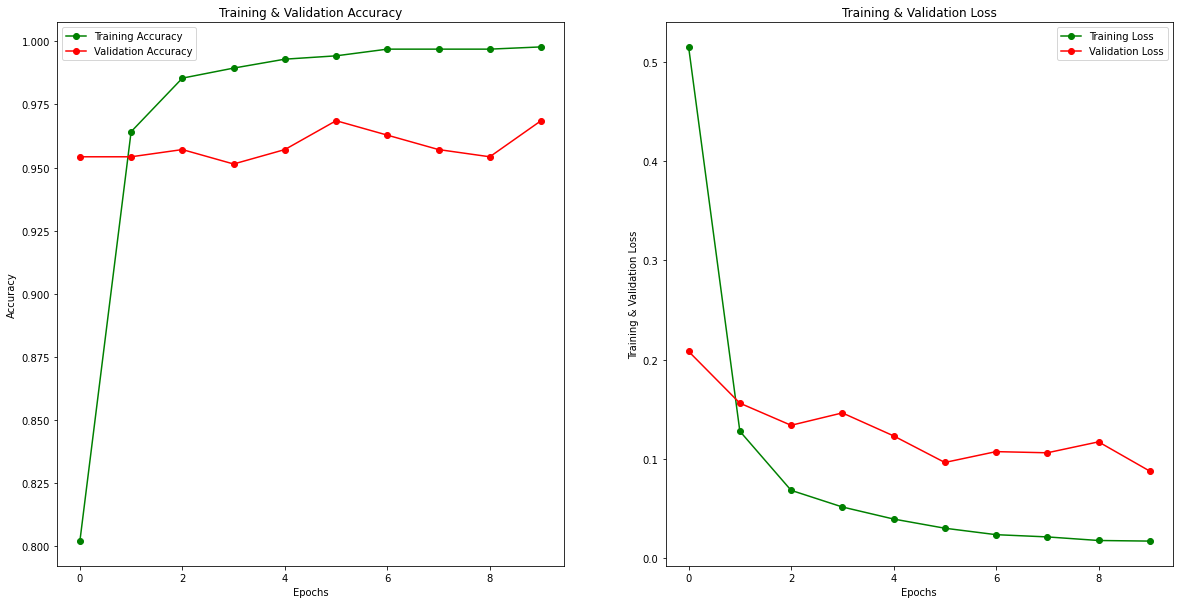

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))


    fig.set_size_inches(20,10)
    ax[0].plot(epochs , accuracy , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_accuracy , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()
plot_accuracy_loss_chart(H)

In [ ]:
model.load_weights("/content/gdrive/My Drive/best_model.h5")

In [ ]:
model.evaluate_generator(test_generator)

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/model.json","w") as json_file:
  json_file.write(model_json)

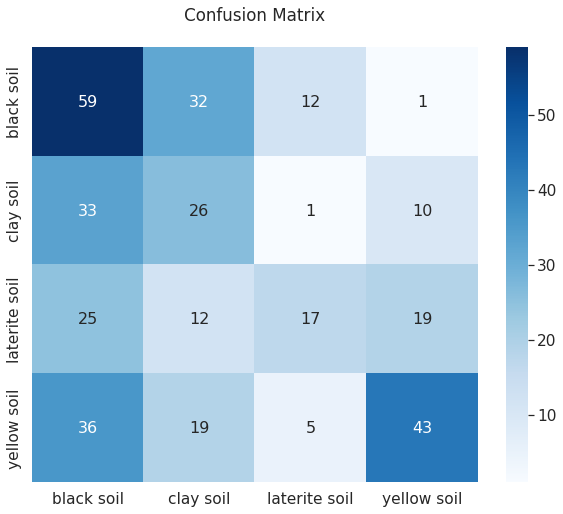

Classification Report

               precision    recall  f1-score   support

   black soil       0.39      0.57      0.46       104
    clay soil       0.29      0.37      0.33        70
laterite soil       0.49      0.23      0.31        73
  yellow soil       0.59      0.42      0.49       103

     accuracy                           0.41       350
    macro avg       0.44      0.40      0.40       350
 weighted avg       0.45      0.41      0.41       350



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
Y_pred = model.predict(test_generator, int(968/44))
y_pred = np.argmax(Y_pred, axis = 1)

cm = confusion_matrix(test_generator.classes, y_pred)
df_cm = pd.DataFrame(cm, list(test_generator.class_indices.keys()), list(test_generator.class_indices.keys()))

fig, ax = plt.subplots(figsize = (10,8))
sns.set(font_scale = 1.4) # for label size
sns.heatmap(df_cm, annot = True, annot_kws = {"size": 16}, cmap = plt.cm.Blues)
plt.title('Confusion Matrix\n')
plt.savefig('confusion_matrix.png', transparent = False, bbox_inches = 'tight', dpi = 400)
plt.show()

print('Classification Report\n')
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names = target_names))